In [1]:
%load_ext autoreload
%autoreload 1
%aimport myutils

In [2]:
import sys

import hiclass
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import sklearn

print('python:'.ljust(16), sys.version.split('\n')[0])
print('hiclass:'.ljust(16), hiclass.__version__)
print('scikit-learn:'.ljust(16), sklearn.__version__)

python:          3.9.12 (main, Apr  5 2022, 01:53:17) 
hiclass:         3.0.3
scikit-learn:    1.0.2


## Define constants

In [3]:
RANDOM_SEED = 2147483647
GRAPH_ROOT = 1

DATA_PATH = './data/'
WORKING_PATH = './working/'

IDENT = 'id'  # ID feature name
TARGET = 'category_id'  # Target feature name
TRAIN = 'TRAIN'  # Binary feature name to separate train and test data
PATH_COLS = ['node_1', 'node_2', 'node_3', 'node_4', 'node_5']

MODEL_TYPE = 'lcpn'  # {'lcpn', 'lcn'}
N_ESTIMATORS = 20
N_WORD_SYMBOLS = 3
VALID_SIZE = 0.2

## Load data

In [4]:
# Load datasets
tree = pd.read_csv(DATA_PATH + 'categories_tree.csv')
df_train = pd.read_parquet(DATA_PATH + 'train.parquet', 'pyarrow')
df_test = pd.read_parquet(DATA_PATH + 'test.parquet', 'pyarrow')

# Join train and test datasets
df_test[TARGET] = pd.NA  # Fill target variable of the test dataset with zeros
df_train[TRAIN] = True  # Train/test flag
df_test[TRAIN] = False  # Train/test flag
df = pd.concat([df_train, df_test], ignore_index=True)

## Prepare graph

In [5]:
# Define graph
edgelist = [tuple(r) for r in tree[['parent_id', 'id']].to_numpy()]
G = nx.from_edgelist(edgelist, create_using=nx.DiGraph)

# Remove nodes that not in df
G.remove_node(0)
df_leaf_nodes = set(df.loc[df[TRAIN], TARGET])
while True:
    graph_leaf_nodes = {x for x in G.nodes() if G.out_degree(x)==0}
    useless_nodes = graph_leaf_nodes - df_leaf_nodes
    if len(useless_nodes) == 0:
        break
    G.remove_nodes_from(useless_nodes)

## Prepare dataframe
### Preprocess

In [6]:
# Add binary column to indicate rating absence (0.0 value)
df['no_rating'] = 0
df.loc[df['rating'] == 0.0, 'no_rating'] = 1

# Replace 0.0 rating with mean value
mean_rating = df.loc[df['rating'] == 0.0, 'rating'].mean()
df.loc[df['rating'].isna(), 'rating'] = mean_rating

# Replace -1 value of feedback quantity with 0
df.loc[df['feedback_quantity'] == -1, 'feedback_quantity'] = 0

# Drop features that will not be used
df.drop(['short_description', 'name_value_characteristics'], axis=1, inplace=True)

### Add columns with path nodes

In [7]:
path_maps = myutils.get_path_map_by_depth(G, GRAPH_ROOT)

path_map_df = pd.DataFrame.from_dict(
    path_maps[-1],
    orient='index',
    dtype=pd.Int64Dtype(),
    columns=PATH_COLS,
)

df = df.join(path_map_df, on=TARGET)

### View df

In [8]:
df.head(2)

,id,title,rating,feedback_quantity,category_id,TRAIN,no_rating,node_1,node_2,node_3,node_4,node_5
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,0.000000,0,2693,True,1,10012,10113,10355,2693,-1
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",4.666667,9,13408,True,0,10020,10044,10398,13408,-1


### Split df on train, valid, test

In [9]:
# Split df
X, X_train, X_valid, X_test, y, y_train, y_valid, _, _ = myutils.split_scale_df(
    df, TRAIN, TARGET, PATH_COLS,
    validation_size=VALID_SIZE, random_state=RANDOM_SEED, stratify=True
)

# Print shapes
pd.DataFrame({'X': {'not test': X.shape, 'train': X_train.shape, 'valid': X_valid.shape, 'test': X_test.shape},
              'y': {'not test': y.shape, 'train': y_train.shape, 'valid': y_valid.shape, 'test': None}})

,X,y
not test,"(283452, 5)","(283452, 5)"
train,"(226761, 5)","(226761, 5)"
valid,"(56691, 5)","(56691, 5)"
test,"(70864, 5)",None


### Vectorize 'title' column

In [10]:
%%time
# Get vectorizer
vectorizer = myutils.get_vectorizer(
    X_train['title'],
    fname=WORKING_PATH + 'bl_vectorizer_w' + str(N_WORD_SYMBOLS) + '_train.joblib',
    stopwords_fname = WORKING_PATH + 'stopwords-ru.txt',
    regexp=r'(?u)\b\w{' + str(N_WORD_SYMBOLS) + r',}\b',
    saving=False,
)

print('Number of vectorized features:', len(vectorizer.vocabulary_))
print()

/Users/admin/opt/anaconda3/envs/kztest/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of vectorized features: 25030

CPU times: user 1min 47s, sys: 160 ms, total: 1min 47s
Wall time: 1min 47s


In [11]:
%%time
# Get 'title' vectors
title_train = myutils.get_title_vectors(
    X_train['title'],
    fname=WORKING_PATH + 'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_train.joblib',
    vectorizer=vectorizer,
    saving=False,
)
title_valid = myutils.get_title_vectors(
    X_valid['title'],
    fname=WORKING_PATH + 'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_valid.joblib',
    vectorizer=vectorizer,
    saving=False,
)

# Add other columns from df
columns = [IDENT, 'rating', 'no_rating', 'feedback_quantity']
X_train = scipy.sparse.hstack((title_train, X_train[columns].values))
X_valid = scipy.sparse.hstack((title_valid, X_valid[columns].values))

# Print shapes
pd.DataFrame({'X': {'train': X_train.shape, 'valid': X_valid.shape},
              'y': {'train': y_train.shape, 'valid': y_valid.shape}})

CPU times: user 2min 14s, sys: 175 ms, total: 2min 14s
Wall time: 2min 14s


,X,y
train,"(226761, 25034)","(226761, 5)"
valid,"(56691, 25034)","(56691, 5)"


## Define classifier and fit

In [ ]:
%%time
# Get classifier
clf = myutils.get_classifier(
    X_train,
    y_train,
    fname=(WORKING_PATH + 'bl_' + MODEL_TYPE + '_w' + str(N_WORD_SYMBOLS)
           + '_est' + str(N_ESTIMATORS) + '_train.joblib'),
    model_type=MODEL_TYPE,
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    saving=False,
)

## Predict

In [13]:
%%time
pred_train = myutils.get_prediction(
    X_train,
    fname=(WORKING_PATH + 'bl_pred_' + MODEL_TYPE + '_w' + str(N_WORD_SYMBOLS)
           + '_est' + str(N_ESTIMATORS) + '_train.joblib'),
    classifier=clf,
    saving=False,
)
pred_valid = myutils.get_prediction(
    X_valid,
    fname=(WORKING_PATH + 'bl_pred_' + MODEL_TYPE + '_w' + str(N_WORD_SYMBOLS)
           + '_est' + str(N_ESTIMATORS) + '_valid.joblib'),
    classifier=clf,
    saving=False,
)
print()

pred_valid


CPU times: user 1min 25s, sys: 1.75 s, total: 1min 26s
Wall time: 1min 15s


array([[10014, 10116, 11379, 12768,    -1],
       [10018, 10115, 10890, 12044,    -1],
       [10014, 10116, 10533, 13143,    -1],
       ...,
       [10014, 10222, 10877, 11602,    -1],
       [10012, 10070, 10918, 13155,    -1],
       [10018, 10115, 10890, 11889,    -1]])

## Compute metric

100%|██████████| 1231/1231 [00:01<00:00, 641.10it/s]


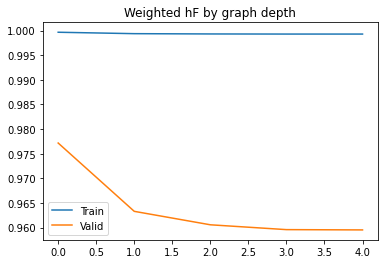


Weighted hF on train: 0.9992859907878867
Weighted hF on valid: 0.9595370094099842


In [14]:
# Compute metrics
whF_train, _ = myutils.get_score_by_depth(path_maps, y_train, pred_train)
whF_valid, _ = myutils.get_score_by_depth(path_maps, y_valid, pred_valid)
print()

# Show whF by graph depth
fig, ax = plt.subplots()
pd.Series(whF_train).plot(ax=ax, legend=True, label='Train')
pd.Series(whF_valid).plot(ax=ax, legend=True, label='Valid')
ax.set_title('Weighted hF by graph depth')
plt.show()
print()

print('Weighted hF on train:', whF_train[-1])
print('Weighted hF on valid:', whF_valid[-1])

## Train on whole data

In [15]:
# Split df
X, _, _, X_test, y, _, _, _, _ = myutils.split_scale_df(
    df, TRAIN, TARGET, PATH_COLS,
    validation_size=VALID_SIZE, random_state=RANDOM_SEED
)

# Print shapes
pd.DataFrame({'X': {'train': X.shape, 'test': X_test.shape},
              'y': {'train': y.shape, 'test': None}})

,X,y
train,"(283452, 5)","(283452, 5)"
test,"(70864, 5)",None


In [16]:
%%time
# Get vectorizer
vectorizer = myutils.get_vectorizer(
    X['title'],
    fname=WORKING_PATH + 'bl_vectorizer_w' + str(N_WORD_SYMBOLS) + '_whole.joblib',
    stopwords_fname=WORKING_PATH + 'stopwords-ru.txt',
    regexp=r'(?u)\b\w{' + str(N_WORD_SYMBOLS) + r',}\b',
    saving=False,
)

print('Number of vectorized features:', len(vectorizer.vocabulary_))
print()

/Users/admin/opt/anaconda3/envs/kztest/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of vectorized features: 28204

CPU times: user 2min 14s, sys: 252 ms, total: 2min 15s
Wall time: 2min 15s


In [17]:
# Get 'title' vectors
title_whole = myutils.get_title_vectors(
    X['title'],
    fname=WORKING_PATH + 'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_whole.joblib',
    vectorizer=vectorizer,
    saving=False,
)
title_test = myutils.get_title_vectors(
    X_test['title'],
    fname=WORKING_PATH + 'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_test.joblib',
    vectorizer=vectorizer,
    saving=False,
)

# Add other columns from df
columns = [IDENT, 'rating', 'no_rating', 'feedback_quantity']
X = scipy.sparse.hstack((title_whole, X[columns].values))
X_test = scipy.sparse.hstack((title_test, X_test[columns].values))

In [ ]:
%%time
# Get classifier
clf = myutils.get_classifier(
    X,
    y,
    fname=(WORKING_PATH + 'bl_' + MODEL_TYPE + '_w' + str(N_WORD_SYMBOLS) 
           + '_est' + str(N_ESTIMATORS) + '_whole.joblib'),
    model_type=MODEL_TYPE,
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    saving=False,
)

In [20]:
%%time
# Predict
pred_whole = myutils.get_prediction(
    X,
    fname=(WORKING_PATH + 'bl_pred_' + MODEL_TYPE + '_w' + str(N_WORD_SYMBOLS)
           + '_est' + str(N_ESTIMATORS) + '_whole.joblib'),
    classifier=clf,
    saving=False,
)
pred_test = myutils.get_prediction(
    X_test,
    fname=(WORKING_PATH + 'bl_pred_' + MODEL_TYPE + '_w' + str(N_WORD_SYMBOLS)
           + '_est' + str(N_ESTIMATORS) + '_test.joblib'),
    classifier=clf,
    saving=False,
)
print()

pred_test


CPU times: user 1min 45s, sys: 1.9 s, total: 1min 47s
Wall time: 1min 32s


array([[10003, 10023, 10104, 11574,    -1],
       [10012, 10165, 10705, 11878,    -1],
       [10020, 10144, 11157,  2803,    -1],
       ...,
       [10014, 10116, 11116, 13205,    -1],
       [10014, 10116, 10500, 13069,    -1],
       [10003, 10023, 10080, 14034,    -1]])

In [21]:
# Compute metric
whF_whole, _ = myutils.get_score(path_maps[-1], y, pred_whole)
print()
print('Weighted hF on train:', whF_whole)

100%|██████████| 1231/1231 [00:11<00:00, 109.25it/s]



Weighted hF on train: 0.9993322035549376


## Submit

In [22]:
submission = pd.DataFrame(
    {'id': df.loc[~df[TRAIN], IDENT],
     'predicted_category_id': myutils.get_leaves(pred_test)}
).reset_index(drop=True)

submission

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,2803
3,1577569,11716
4,869328,12813
...,...,...
70859,967535,13143
70860,1488636,12718
70861,827510,13205
70862,529244,13069


In [23]:
submission.to_parquet('result.parquet', 'pyarrow')